In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Once Google Drive is mounted, you can access your files by specifying the path starting with `/content/drive/MyDrive/`. For example, if you have a file named `my_data.csv` in your Google Drive's root folder, you would access it like this:

Output folder: /content/drive/MyDrive/MIE1517/transformed_image

TESTING ON IMAGE: 8308.jpg
TABLE VIEW TRANSFORMATION - SMART EXTRAPOLATION

[1/7] Running YOLO detection...
  Detected: 1 table, 9 objects
[2/7] Extracting table mask and contour...
  Extracted contour: 818 points
[3/7] Classifying corner visibility...
  Corner visibility:
    TL: (135.0, 46.0) - VISIBLE ✓
    TR: (526.0, 46.0) - VISIBLE ✓
    BR: (619.0, 577.0) - INVISIBLE (cut-off)
    BL: (10.0, 573.0) - INVISIBLE (cut-off)
[4/7] Smart line fitting (preserve visible corners)...
  Top edge: Using EXACT corners (both visible)
  Right edge: Using RANSAC (one/both corners invisible)
  Bottom edge: Using RANSAC (one/both corners invisible)
  Left edge: Using RANSAC (one/both corners invisible)
[5/7] Extrapolating only invisible corners...
  TL: KEEPING original (135.0, 46.0)
  TR: KEEPING original (526.0, 46.0)
  BR: EXTRAPOLATED to (717.7, 570.0) [OUTSIDE FRAME]
  BL: EXTRAPOLATED to (-61.7, 574.7) [OUTSIDE FRAME]
[6/7] Cr

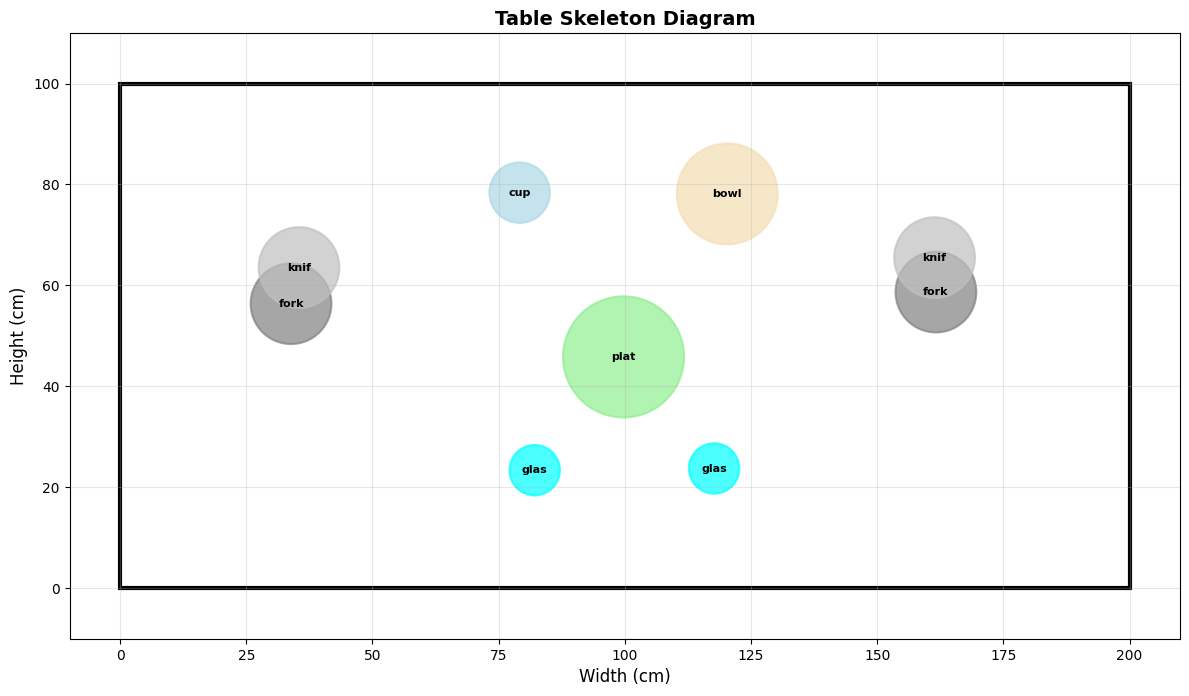

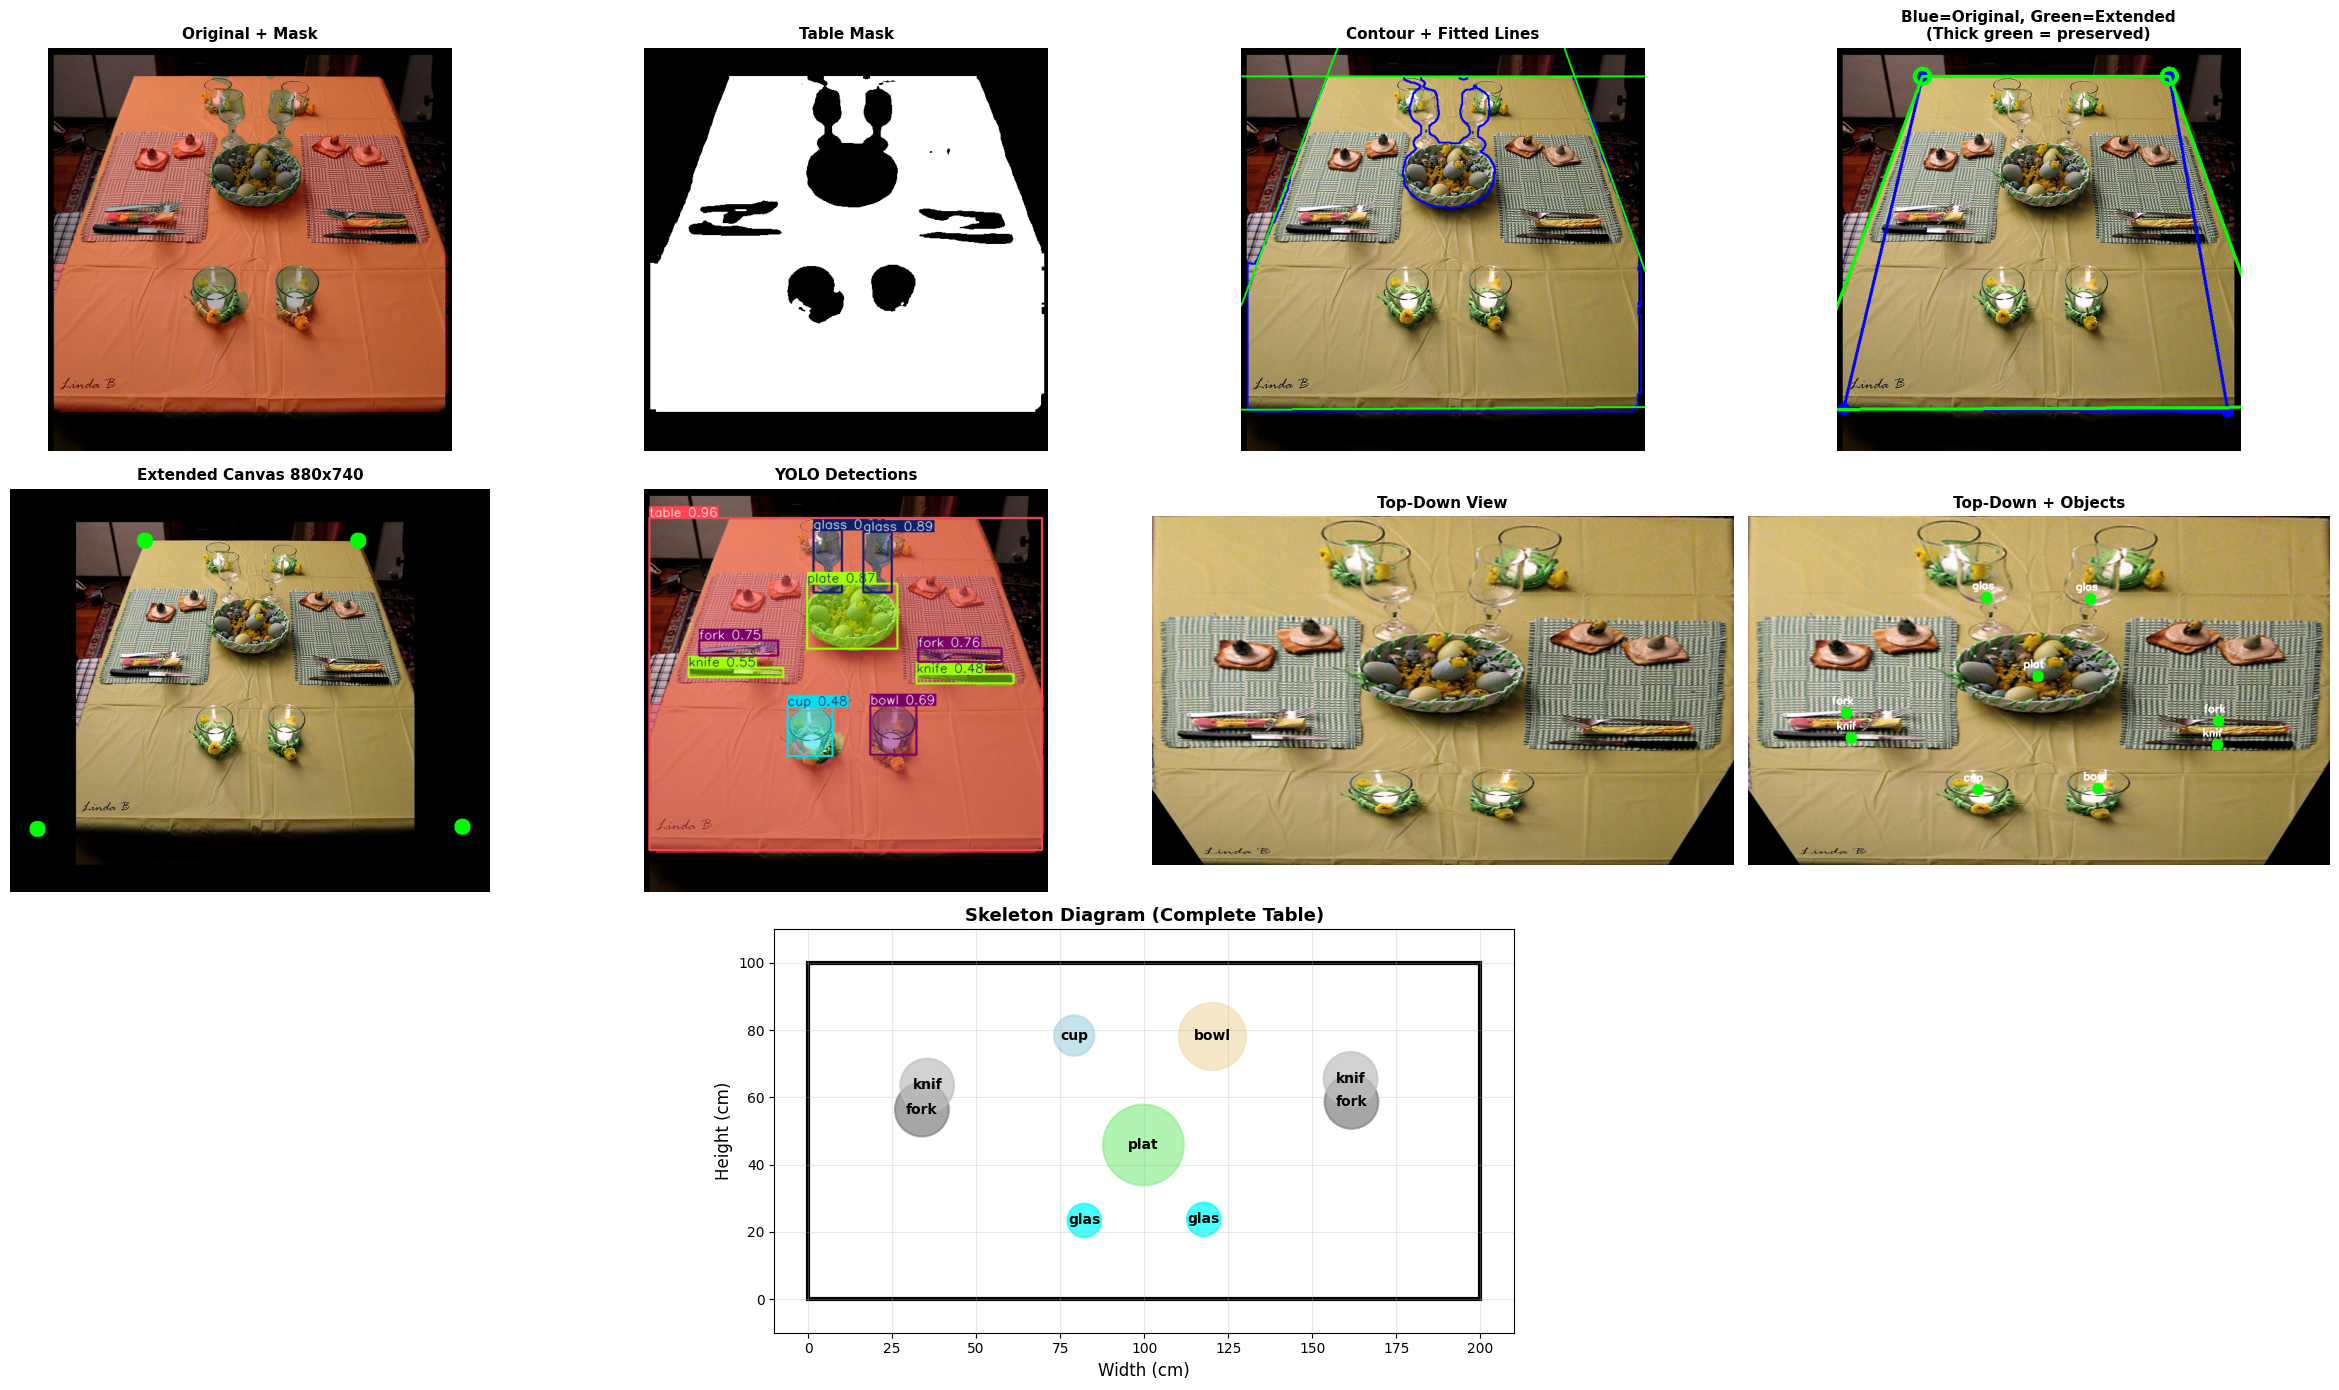


CORNER COMPARISON
Original corners:
  Corner 0: (135.0, 46.0)
  Corner 1: (526.0, 46.0)
  Corner 2: (619.0, 577.0)
  Corner 3: (10.0, 573.0)

Extended corners:
  Corner 0: (135.0, 46.0) - KEPT (visible)
  Corner 1: (526.0, 46.0) - KEPT (visible)
  Corner 2: (717.7, 570.0) - EXTRAPOLATED
  Corner 3: (-61.7, 574.7) - EXTRAPOLATED

SAVING OUTPUTS
✓ Top-down: /content/drive/MyDrive/MIE1517/transformed_image/top_down_8308.jpg
✓ Canvas: /content/drive/MyDrive/MIE1517/transformed_image/extended_canvas_8308.jpg
✓ Mask: /content/drive/MyDrive/MIE1517/transformed_image/table_mask_8308.jpg
✓ Skeleton: /content/drive/MyDrive/MIE1517/transformed_image/skeleton_8308.png
✓ Data: /content/drive/MyDrive/MIE1517/transformed_image/transformation_data_8308.json
✓ Visualization: /content/drive/MyDrive/MIE1517/transformed_image/transformation_8308.png

✓ All results saved successfully!


In [3]:
"""
Table View Transformation - COMPLETE CORRECTED VERSION
"""

import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.spatial import ConvexHull
from sklearn.linear_model import RANSACRegressor, LinearRegression
import warnings
import os
warnings.filterwarnings('ignore')

class TableViewTransformerExtended:
    """Complete pipeline with smart corner extrapolation"""
    
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.image = None
        self.results = None
        self.table_mask_binary = None
        self.table_contour = None
        self.objects = []
        self.table_corners = None
        self.table_corners_extended = None
        self.corner_visibility = None
        self.edge_lines = None
        self.extended_canvas = None
        self.canvas_offset = None
        self.homography_matrix = None
        self.top_down_image = None
        self.skeleton_data = None
        
    def process(self, image_path, conf_threshold=0.20):
        """Complete processing pipeline"""
        print("="*70)
        print("TABLE VIEW TRANSFORMATION - SMART EXTRAPOLATION")
        print("="*70)
        
        print("\n[1/7] Running YOLO detection...")
        self.detect(image_path, conf_threshold)
        
        print("[2/7] Extracting table mask and contour...")
        self.extract_table_contour()
        
        print("[3/7] Classifying corner visibility...")
        self.classify_corners()
        
        print("[4/7] Smart line fitting (preserve visible corners)...")
        self.fit_edge_lines_smart()
        
        print("[5/7] Extrapolating only invisible corners...")
        self.extrapolate_corners_smart()
        
        print("[6/7] Creating extended canvas and homography...")
        self.create_extended_canvas()
        
        print("[7/7] Applying transformation and generating outputs...")
        self.apply_transformation()
        self.normalize_coordinates()
        self.generate_skeleton()
        
        print("\n✓ Pipeline complete!")
        
        return {
            'original_image': self.image,
            'extended_canvas': self.extended_canvas,
            'table_mask': self.table_mask_binary,
            'table_corners_original': self.table_corners,
            'table_corners_extended': self.table_corners_extended,
            'corner_visibility': self.corner_visibility,
            'top_down_image': self.top_down_image,
            'skeleton_diagram': self.skeleton_data,
            'objects': self.objects
        }
    
    def detect(self, image_path, conf_threshold=0.20):
        """Step 1: YOLO Detection"""
        self.image = cv2.imread(image_path)
        self.results = self.model.predict(image_path, conf=conf_threshold, verbose=False)[0]
        
        img_h, img_w = self.image.shape[:2]
        self.img_height = img_h
        self.img_width = img_w
        
        self.table_mask_binary = None
        self.objects = []
        
        for i, box in enumerate(self.results.boxes):
            class_id = int(box.cls)
            class_name = self.model.names[class_id]
            confidence = float(box.conf)
            bbox = box.xyxy[0].cpu().numpy()
            centroid = [(bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2]
            
            mask = None
            if self.results.masks is not None and i < len(self.results.masks):
                mask_data = self.results.masks[i].data[0].cpu().numpy()
                
                if class_name == 'table':
                    self.table_mask_binary = (mask_data * 255).astype(np.uint8)
                    self.table_mask_binary = cv2.resize(
                        self.table_mask_binary, 
                        (img_w, img_h), 
                        interpolation=cv2.INTER_NEAREST
                    )
                else:
                    mask = self.results.masks[i].xy[0]
            
            if class_name != 'table':
                self.objects.append({
                    'class': class_name,
                    'confidence': confidence,
                    'bbox': bbox,
                    'centroid': centroid,
                    'mask': mask
                })
        
        print(f"  Detected: 1 table, {len(self.objects)} objects")
        
        if self.table_mask_binary is None:
            raise ValueError("No table detected in image!")
    
    def extract_table_contour(self):
        """Step 2: Extract contour from mask"""
        contours, _ = cv2.findContours(
            self.table_mask_binary, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        if len(contours) == 0:
            raise ValueError("No contour found in table mask!")
        
        self.table_contour = max(contours, key=cv2.contourArea)
        print(f"  Extracted contour: {len(self.table_contour)} points")
        
        contour_points = self.table_contour.reshape(-1, 2)
        self.table_corners = self._get_four_corners(contour_points)
        self.table_corners = self._order_corners(self.table_corners)
    
    def classify_corners(self):
        """Step 3: Classify each corner as visible or invisible"""
        margin = 30
        
        self.corner_visibility = []
        
        for i, corner in enumerate(self.table_corners):
            x, y = corner
            is_visible = (
                margin < x < self.img_width - margin and
                margin < y < self.img_height - margin
            )
            self.corner_visibility.append(is_visible)
        
        labels = ['TL', 'TR', 'BR', 'BL']
        print(f"  Corner visibility:")
        for i, label in enumerate(labels):
            status = "VISIBLE ✓" if self.corner_visibility[i] else "INVISIBLE (cut-off)"
            x, y = self.table_corners[i]
            print(f"    {label}: ({x:.1f}, {y:.1f}) - {status}")
    
    def fit_edge_lines_smart(self):
        """Step 4: Fit lines, using exact corners when both endpoints visible"""
        self.edge_lines = {}
        
        # Top edge (TL to TR)
        if self.corner_visibility[0] and self.corner_visibility[1]:
            self.edge_lines['top'] = self._line_from_two_points(
                self.table_corners[0], self.table_corners[1]
            )
            print("  Top edge: Using EXACT corners (both visible)")
        else:
            line = self._fit_edge_line_ransac('top')
            if line is not None:
                self.edge_lines['top'] = line
                print("  Top edge: Using RANSAC (one/both corners invisible)")
        
        # Right edge (TR to BR)
        if self.corner_visibility[1] and self.corner_visibility[2]:
            self.edge_lines['right'] = self._line_from_two_points(
                self.table_corners[1], self.table_corners[2]
            )
            print("  Right edge: Using EXACT corners (both visible)")
        else:
            line = self._fit_edge_line_ransac('right')
            if line is not None:
                self.edge_lines['right'] = line
                print("  Right edge: Using RANSAC (one/both corners invisible)")
        
        # Bottom edge (BR to BL)
        if self.corner_visibility[2] and self.corner_visibility[3]:
            self.edge_lines['bottom'] = self._line_from_two_points(
                self.table_corners[2], self.table_corners[3]
            )
            print("  Bottom edge: Using EXACT corners (both visible)")
        else:
            line = self._fit_edge_line_ransac('bottom')
            if line is not None:
                self.edge_lines['bottom'] = line
                print("  Bottom edge: Using RANSAC (one/both corners invisible)")
        
        # Left edge (BL to TL)
        if self.corner_visibility[3] and self.corner_visibility[0]:
            self.edge_lines['left'] = self._line_from_two_points(
                self.table_corners[3], self.table_corners[0]
            )
            print("  Left edge: Using EXACT corners (both visible)")
        else:
            line = self._fit_edge_line_ransac('left')
            if line is not None:
                self.edge_lines['left'] = line
                print("  Left edge: Using RANSAC (one/both corners invisible)")
    
    def _line_from_two_points(self, p1, p2):
        """Create exact line equation from two points: ax + by + c = 0"""
        x1, y1 = p1
        x2, y2 = p2
        
        a = y2 - y1
        b = -(x2 - x1)
        c = (x2 - x1) * y1 - (y2 - y1) * x1
        
        norm = np.sqrt(a**2 + b**2)
        if norm > 1e-6:
            return (a/norm, b/norm, c/norm)
        else:
            return (a, b, c)
    
    def _fit_edge_line_ransac(self, edge_name):
        """Fit line to edge points using RANSAC"""
        contour_points = self.table_contour.reshape(-1, 2)
        
        if edge_name == 'top':
            points = contour_points[contour_points[:, 1] < self.img_height * 0.3]
        elif edge_name == 'bottom':
            points = contour_points[contour_points[:, 1] > self.img_height * 0.7]
        elif edge_name == 'left':
            points = contour_points[contour_points[:, 0] < self.img_width * 0.3]
        elif edge_name == 'right':
            points = contour_points[contour_points[:, 0] > self.img_width * 0.7]
        else:
            return None
        
        if len(points) < 5:
            return None
        
        try:
            X = points[:, 0].reshape(-1, 1)
            y = points[:, 1]
            
            ransac = RANSACRegressor(random_state=42, min_samples=5, residual_threshold=5.0)
            ransac.fit(X, y)
            
            m = ransac.estimator_.coef_[0]
            b = ransac.estimator_.intercept_
            
            a = m
            b_coef = -1
            c = b
            
            norm = np.sqrt(a**2 + b_coef**2)
            return (a/norm, b_coef/norm, c/norm)
        except:
            return None
    
    def extrapolate_corners_smart(self):
        """Step 5: Keep visible corners, extrapolate invisible ones"""
        if len(self.edge_lines) < 2:
            print("  Warning: Not enough edges, using original corners")
            self.table_corners_extended = self.table_corners.copy()
            return
        
        extended_corners = []
        labels = ['TL', 'TR', 'BR', 'BL']
        edge_pairs = [
            ('top', 'left'),
            ('top', 'right'),
            ('bottom', 'right'),
            ('bottom', 'left')
        ]
        
        for i in range(4):
            if self.corner_visibility[i]:
                extended_corners.append(self.table_corners[i])
                print(f"  {labels[i]}: KEEPING original ({self.table_corners[i][0]:.1f}, {self.table_corners[i][1]:.1f})")
            else:
                edge1, edge2 = edge_pairs[i]
                
                if edge1 in self.edge_lines and edge2 in self.edge_lines:
                    corner = self._line_intersection(
                        self.edge_lines[edge1], 
                        self.edge_lines[edge2]
                    )
                    if corner is not None:
                        extended_corners.append(corner)
                        outside = ""
                        if corner[0] < 0 or corner[0] > self.img_width or corner[1] < 0 or corner[1] > self.img_height:
                            outside = " [OUTSIDE FRAME]"
                        print(f"  {labels[i]}: EXTRAPOLATED to ({corner[0]:.1f}, {corner[1]:.1f}){outside}")
                    else:
                        extended_corners.append(self.table_corners[i])
                        print(f"  {labels[i]}: Failed to extrapolate, using original")
                else:
                    extended_corners.append(self.table_corners[i])
                    print(f"  {labels[i]}: Missing edges, using original")
        
        self.table_corners_extended = np.array(extended_corners, dtype=np.float32)
    
    def _line_intersection(self, line1, line2):
        """Find intersection of two lines"""
        a1, b1, c1 = line1
        a2, b2, c2 = line2
        
        det = a1 * b2 - a2 * b1
        
        if abs(det) < 1e-6:
            return None
        
        x = (b1 * c2 - b2 * c1) / det
        y = (a2 * c1 - a1 * c2) / det
        
        return np.array([x, y])
    
    def create_extended_canvas(self):
        """Step 6: Create expanded canvas"""
        min_x = np.min(self.table_corners_extended[:, 0])
        max_x = np.max(self.table_corners_extended[:, 0])
        min_y = np.min(self.table_corners_extended[:, 1])
        max_y = np.max(self.table_corners_extended[:, 1])
        
        min_x = min(min_x, 0)
        max_x = max(max_x, self.img_width)
        min_y = min(min_y, 0)
        max_y = max(max_y, self.img_height)
        
        padding = 50
        min_x -= padding
        max_x += padding
        min_y -= padding
        max_y += padding
        
        canvas_width = int(np.ceil(max_x - min_x))
        canvas_height = int(np.ceil(max_y - min_y))
        
        self.canvas_offset = (-int(np.floor(min_x)), -int(np.floor(min_y)))
        
        print(f"  Extended canvas: {canvas_width}x{canvas_height} px")
        print(f"  Original offset: {self.canvas_offset}")
        
        offset_x, offset_y = self.canvas_offset
        required_width = offset_x + self.img_width
        required_height = offset_y + self.img_height
        
        if canvas_width < required_width or canvas_height < required_height:
            canvas_width = max(canvas_width, required_width + 50)
            canvas_height = max(canvas_height, required_height + 50)
        
        self.extended_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
        self.extended_canvas[offset_y:offset_y+self.img_height, 
                            offset_x:offset_x+self.img_width] = self.image
        
        self.table_corners_canvas = self.table_corners_extended.copy()
        self.table_corners_canvas[:, 0] += self.canvas_offset[0]
        self.table_corners_canvas[:, 1] += self.canvas_offset[1]
        
        target_width = 1000
        target_height = 600
        
        dst_corners = np.array([
            [0, 0],
            [target_width, 0],
            [target_width, target_height],
            [0, target_height]
        ], dtype=np.float32)
        
        self.homography_matrix, _ = cv2.findHomography(self.table_corners_canvas, dst_corners)
        self.target_width = target_width
        self.target_height = target_height
    
    def apply_transformation(self):
        """Step 7: Apply transformation"""
        self.top_down_image = cv2.warpPerspective(
            self.extended_canvas,
            self.homography_matrix,
            (self.target_width, self.target_height)
        )
        
        for obj in self.objects:
            centroid_img = np.array(obj['centroid'])
            centroid_canvas = centroid_img + np.array(self.canvas_offset)
            
            centroid = np.array([[centroid_canvas]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(centroid, self.homography_matrix)
            obj['centroid_transformed'] = transformed[0][0]
            
            if obj['mask'] is not None:
                mask_canvas = obj['mask'] + np.array(self.canvas_offset)
                mask_points = mask_canvas.reshape(-1, 1, 2).astype(np.float32)
                transformed_mask = cv2.perspectiveTransform(mask_points, self.homography_matrix)
                obj['mask_transformed'] = transformed_mask.reshape(-1, 2)
    
    def normalize_coordinates(self, table_width_cm=200, table_height_cm=100):
        """Normalize to real-world coordinates"""
        px_to_cm_x = table_width_cm / self.target_width
        px_to_cm_y = table_height_cm / self.target_height
        
        for obj in self.objects:
            x_cm = obj['centroid_transformed'][0] * px_to_cm_x
            y_cm = obj['centroid_transformed'][1] * px_to_cm_y
            obj['position_cm'] = [x_cm, y_cm]
    
    def generate_skeleton(self):
        """Generate skeleton diagram"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        table_rect = Rectangle((0, 0), 200, 100, 
                               fill=False, edgecolor='black', linewidth=3)
        ax.add_patch(table_rect)
        
        class_colors = {
            'plate': 'lightgreen', 'cup': 'lightblue', 'glass': 'cyan',
            'fork': 'gray', 'knife': 'silver', 'spoon': 'lightgray', 
            'saucer': 'wheat', 'bowl': 'wheat'
        }
        
        class_sizes = {
            'plate': 12, 'cup': 6, 'glass': 5, 'fork': 8, 'knife': 8, 
            'spoon': 6, 'saucer': 10, 'bowl': 10
        }
        
        for obj in self.objects:
            x, y = obj['position_cm']
            class_name = obj['class']
            
            color = class_colors.get(class_name, 'orange')
            size = class_sizes.get(class_name, 8)
            
            circle = Circle((x, y), size, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
            ax.add_patch(circle)
            ax.text(x, y, class_name[:4], ha='center', va='center', 
                   fontsize=8, fontweight='bold')
        
        ax.set_xlim(-10, 210)
        ax.set_ylim(-10, 110)
        ax.set_aspect('equal')
        ax.set_xlabel('Width (cm)', fontsize=12)
        ax.set_ylabel('Height (cm)', fontsize=12)
        ax.set_title('Table Skeleton Diagram', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        self.skeleton_data = fig
    
    def _get_four_corners(self, points):
        """Get 4 extreme corner points"""
        top_left = points[np.argmin(points[:, 0] + points[:, 1])]
        top_right = points[np.argmax(points[:, 0] - points[:, 1])]
        bottom_right = points[np.argmax(points[:, 0] + points[:, 1])]
        bottom_left = points[np.argmin(points[:, 0] - points[:, 1])]
        
        return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)
    
    def _order_corners(self, corners):
        """Order corners properly"""
        centroid = np.mean(corners, axis=0)
        angles = np.arctan2(corners[:, 1] - centroid[1], corners[:, 0] - centroid[0])
        sorted_indices = np.argsort(angles)
        sums = corners[:, 0] + corners[:, 1]
        tl_idx = np.argmin(sums)
        ordered = np.roll(corners[sorted_indices], -np.where(sorted_indices == tl_idx)[0][0], axis=0)
        return ordered.astype(np.float32)
    
    def visualize_results(self, save_path=None):
        """Visualize comprehensive results"""
        fig = plt.figure(figsize=(24, 14))
        
        # 1. Original + Mask
        ax1 = plt.subplot(3, 4, 1)
        img_with_mask = self.image.copy()
        mask_colored = np.zeros_like(self.image)
        mask_colored[:, :, 2] = self.table_mask_binary
        img_with_mask = cv2.addWeighted(img_with_mask, 0.7, mask_colored, 0.3, 0)
        ax1.imshow(cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original + Mask', fontsize=11, fontweight='bold')
        ax1.axis('off')
        
        # 2. Table Mask
        ax2 = plt.subplot(3, 4, 2)
        ax2.imshow(self.table_mask_binary, cmap='gray')
        ax2.set_title('Table Mask', fontsize=11, fontweight='bold')
        ax2.axis('off')
        
        # 3. Contour + Fitted Lines
        ax3 = plt.subplot(3, 4, 3)
        img_lines = self.image.copy()
        cv2.drawContours(img_lines, [self.table_contour], -1, (255, 0, 0), 2)
        
        for edge_name, (a, b, c) in self.edge_lines.items():
            if abs(b) > 0.1:
                x1, x2 = 0, self.img_width
                y1 = (-c - a * x1) / b
                y2 = (-c - a * x2) / b
                cv2.line(img_lines, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            else:
                x = -c / a
                cv2.line(img_lines, (int(x), 0), (int(x), self.img_height), (0, 255, 0), 2)
        
        ax3.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
        ax3.set_title('Contour + Fitted Lines', fontsize=11, fontweight='bold')
        ax3.axis('off')
        
        # 4. Blue=Original, Green=Extended
        ax4 = plt.subplot(3, 4, 4)
        img_corners = self.image.copy()
        
        # Draw original corners (blue)
        for i, corner in enumerate(self.table_corners):
            cv2.circle(img_corners, tuple(corner.astype(int)), 10, (255, 0, 0), -1)
        cv2.polylines(img_corners, [self.table_corners.astype(int)], True, (255, 0, 0), 3)
        
        # Draw extended corners (green)
        for i, corner in enumerate(self.table_corners_extended):
            x, y = corner.astype(int)
            if -200 < x < self.img_width + 200 and -200 < y < self.img_height + 200:
                thickness = 5 if self.corner_visibility[i] else 3
                cv2.circle(img_corners, (x, y), 12, (0, 255, 0), thickness)
                
        cv2.polylines(img_corners, [self.table_corners_extended.astype(int)], True, (0, 255, 0), 3)
        
        ax4.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
        ax4.set_title('Blue=Original, Green=Extended\n(Thick green = preserved)', fontsize=11, fontweight='bold')
        ax4.axis('off')
        
        # 5. Extended Canvas
        ax5 = plt.subplot(3, 4, 5)
        canvas_vis = self.extended_canvas.copy()
        for i, corner in enumerate(self.table_corners_canvas):
            cv2.circle(canvas_vis, tuple(corner.astype(int)), 15, (0, 255, 0), -1)
        ax5.imshow(cv2.cvtColor(canvas_vis, cv2.COLOR_BGR2RGB))
        ax5.set_title(f'Extended Canvas {canvas_vis.shape[1]}x{canvas_vis.shape[0]}', 
                     fontsize=11, fontweight='bold')
        ax5.axis('off')
        
        # 6. YOLO Detections
        ax6 = plt.subplot(3, 4, 6)
        detection_img = self.results.plot()
        ax6.imshow(detection_img[..., ::-1])
        ax6.set_title('YOLO Detections', fontsize=11, fontweight='bold')
        ax6.axis('off')
        
        # 7. Top-down View
        ax7 = plt.subplot(3, 4, 7)
        ax7.imshow(cv2.cvtColor(self.top_down_image, cv2.COLOR_BGR2RGB))
        ax7.set_title('Top-Down View', fontsize=11, fontweight='bold')
        ax7.axis('off')
        
        # 8. Top-down + Objects
        ax8 = plt.subplot(3, 4, 8)
        top_down_annotated = self.top_down_image.copy()
        for obj in self.objects:
            x, y = obj['centroid_transformed'].astype(int)
            cv2.circle(top_down_annotated, (x, y), 10, (0, 255, 0), -1)
            cv2.putText(top_down_annotated, obj['class'][:4], (x-25, y-15),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        ax8.imshow(cv2.cvtColor(top_down_annotated, cv2.COLOR_BGR2RGB))
        ax8.set_title('Top-Down + Objects', fontsize=11, fontweight='bold')
        ax8.axis('off')
        
        # 9-12. Skeleton Diagram
        ax9 = plt.subplot(3, 4, (9, 12))
        table_rect = Rectangle((0, 0), 200, 100, 
                               fill=False, edgecolor='black', linewidth=3)
        ax9.add_patch(table_rect)
        
        class_colors = {
            'plate': 'lightgreen', 'cup': 'lightblue', 'glass': 'cyan',
            'fork': 'gray', 'knife': 'silver', 'spoon': 'lightgray', 
            'saucer': 'wheat', 'bowl': 'wheat'
        }
        class_sizes = {
            'plate': 12, 'cup': 6, 'glass': 5, 'fork': 8, 'knife': 8, 
            'spoon': 6, 'saucer': 10, 'bowl': 10
        }
        
        for obj in self.objects:
            x, y = obj['position_cm']
            color = class_colors.get(obj['class'], 'orange')
            size = class_sizes.get(obj['class'], 8)
            circle = Circle((x, y), size, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
            ax9.add_patch(circle)
            ax9.text(x, y, obj['class'][:4], ha='center', va='center', 
                    fontsize=10, fontweight='bold')
        
        ax9.set_xlim(-10, 210)
        ax9.set_ylim(-10, 110)
        ax9.set_aspect('equal')
        ax9.set_xlabel('Width (cm)', fontsize=12)
        ax9.set_ylabel('Height (cm)', fontsize=12)
        ax9.set_title('Skeleton Diagram (Complete Table)', fontsize=13, fontweight='bold')
        ax9.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"\n✓ Visualization saved to: {save_path}")
        
        plt.show()
    
    def export_data(self):
        """Export all data (JSON-serializable)"""
        return {
            'table_corners_original': self.table_corners.astype(float).tolist(),
            'table_corners_extended': self.table_corners_extended.astype(float).tolist(),
            'corner_visibility': [bool(x) for x in self.corner_visibility],
            'canvas_size': [int(self.extended_canvas.shape[1]), int(self.extended_canvas.shape[0])],
            'canvas_offset': [int(self.canvas_offset[0]), int(self.canvas_offset[1])],
            'homography_matrix': self.homography_matrix.astype(float).tolist(),
            'edge_lines_detected': list(self.edge_lines.keys()),
            'objects': [
                {
                    'class': obj['class'],
                    'confidence': float(obj['confidence']),
                    'original_position': [float(x) for x in obj['centroid']],
                    'top_down_position_px': [float(x) for x in obj['centroid_transformed']],
                    'real_world_position_cm': [float(x) for x in obj['position_cm']]
                }
                for obj in self.objects
            ]
        }


# ============================================================================
# TEST ON IMAGE 8308
# ============================================================================

if __name__ == "__main__":
    import json
    from pathlib import Path
    
    # Create output folder
    output_folder = '/content/drive/MyDrive/MIE1517/transformed_image'
    os.makedirs(output_folder, exist_ok=True)
    print(f"Output folder: {output_folder}")
    
    model_path = r'C:\Users\Owner\Desktop\MIE1517\project\runs\segment\tableware_yolov11m\weights\best.pt'
    test_image_path = r'C:\Users\Owner\Desktop\MIE1517\project\YOLO_dataset\test\images\8308.jpg'
    
    print("\n" + "="*70)
    print("TESTING ON IMAGE: 8308.jpg")
    print("="*70)
    
    transformer = TableViewTransformerExtended(model_path)
    results = transformer.process(test_image_path, conf_threshold=0.20)
    
    # Save visualization
    transformer.visualize_results(save_path=f'{output_folder}/transformation_8308.png')
    
    # Export data
    data = transformer.export_data()
    
    print("\n" + "="*70)
    print("CORNER COMPARISON")
    print("="*70)
    print("Original corners:")
    for i, corner in enumerate(data['table_corners_original']):
        print(f"  Corner {i}: ({corner[0]:.1f}, {corner[1]:.1f})")
    
    print("\nExtended corners:")
    for i, corner in enumerate(data['table_corners_extended']):
        visibility = "KEPT (visible)" if data['corner_visibility'][i] else "EXTRAPOLATED"
        print(f"  Corner {i}: ({corner[0]:.1f}, {corner[1]:.1f}) - {visibility}")
    
    print("\n" + "="*70)
    print("SAVING OUTPUTS")
    print("="*70)
    
    cv2.imwrite(f'{output_folder}/top_down_8308.jpg', results['top_down_image'])
    cv2.imwrite(f'{output_folder}/extended_canvas_8308.jpg', results['extended_canvas'])
    cv2.imwrite(f'{output_folder}/table_mask_8308.jpg', results['table_mask'])
    
    results['skeleton_diagram'].savefig(f'{output_folder}/skeleton_8308.png', dpi=150, bbox_inches='tight')
    
    with open(f'{output_folder}/transformation_data_8308.json', 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"✓ Top-down: {output_folder}/top_down_8308.jpg")
    print(f"✓ Canvas: {output_folder}/extended_canvas_8308.jpg")
    print(f"✓ Mask: {output_folder}/table_mask_8308.jpg")
    print(f"✓ Skeleton: {output_folder}/skeleton_8308.png")
    print(f"✓ Data: {output_folder}/transformation_data_8308.json")
    print(f"✓ Visualization: {output_folder}/transformation_8308.png")
    
    print("\n✓ All results saved successfully!")